In [13]:
import pandas
import konlpy
import gensim


import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter


print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [14]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [15]:
# from konlpy.tag import Mecab
# import numpy as np
# from collections import Counter

# tokenizer = Mecab()
# stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# def load_data(train_data, test_data, num_words=num_words):
    # [[YOUR CODE]]

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 


In [16]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [17]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

3) 모델 구성을 위한 데이터 분석 및 가공
데이터셋 내 문장 길이 분포
적절한 최대 문장 길이 지정
keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [18]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [19]:
decoded_sentences = get_decoded_sentences(X_train, index_to_word)

In [20]:
print(decoded_sentences[0:5])

['더 빙 . . 진짜 짜증 나 네요 목소리', '. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나', '재 ', '이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정', '익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던   너무나 이뻐 보였 다']


In [21]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+1) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다.

<BOS>


In [22]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [23]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
X_train[0]

(146182, 41)


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  32,  74, 919,   4,   4,  39, 228,  20,
        33, 748], dtype=int32)

train의 일부를 validation
train, validation을 80:20

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                          y_train,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=34)

LSTM모델

In [25]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 41  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(512))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 41)          410000    
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1134592   
_________________________________________________________________
dense (Dense)                (None, 8)                 4104      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,548,705
Trainable params: 1,548,705
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

earlystopping, 과적합을 방지

In [27]:
from keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

In [28]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,callbacks=[es],
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 21s 58ms/step - loss: 0.4489 - accuracy: 0.7839 - val_loss: 0.3595 - val_accuracy: 0.8438
Epoch 2/20
229/229 [==============================] - 13s 57ms/step - loss: 0.3298 - accuracy: 0.8593 - val_loss: 0.3522 - val_accuracy: 0.8471
Epoch 3/20
229/229 [==============================] - 13s 58ms/step - loss: 0.3085 - accuracy: 0.8703 - val_loss: 0.3468 - val_accuracy: 0.8511
Epoch 4/20
229/229 [==============================] - 13s 57ms/step - loss: 0.2848 - accuracy: 0.8813 - val_loss: 0.3496 - val_accuracy: 0.8468
Epoch 5/20
229/229 [==============================] - 13s 57ms/step - loss: 0.2617 - accuracy: 0.8922 - val_loss: 0.3357 - val_accuracy: 0.8574
Epoch 6/20
229/229 [==============================] - 13s 56ms/step - loss: 0.2394 - accuracy: 0.9022 - val_loss: 0.3427 - val_accuracy: 0.8568
Epoch 7/20
229/229 [==============================] - 13s 56ms/step - loss: 0.2185 - accuracy: 0.9122 - val_loss: 0.3709 - val_accuracy:

In [29]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.5715 - accuracy: 0.8393
[0.5715211033821106, 0.8392701148986816]


In [30]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


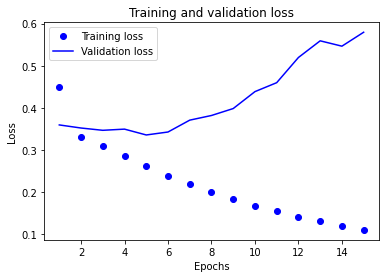

In [31]:
history_dict = history.history
print(history_dict.keys())
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

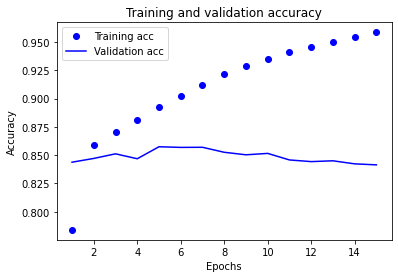

In [32]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1-D CNN 적용

In [33]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          4608      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [34]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,callbacks=[es],
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 6ms/step - loss: 0.4986 - accuracy: 0.7409 - val_loss: 0.3597 - val_accuracy: 0.8439
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3205 - accuracy: 0.8642 - val_loss: 0.3420 - val_accuracy: 0.8510
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2816 - accuracy: 0.8827 - val_loss: 0.3427 - val_accuracy: 0.8524
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2478 - accuracy: 0.9005 - val_loss: 0.3555 - val_accuracy: 0.8518
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2088 - accuracy: 0.9200 - val_loss: 0.3713 - val_accuracy: 0.8501
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1662 - accuracy: 0.9402 - val_loss: 0.4139 - val_accuracy: 0.8470
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1265 - accuracy: 0.9568 - val_loss: 0.4625 - val_accuracy: 0.8433
Epoch 

In [36]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.7770 - accuracy: 0.8266
[0.777021586894989, 0.8265760540962219]


In [37]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


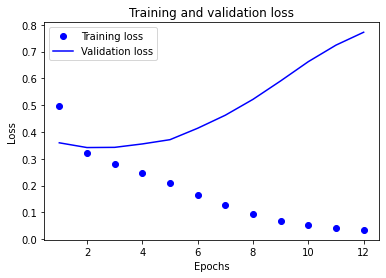

In [38]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

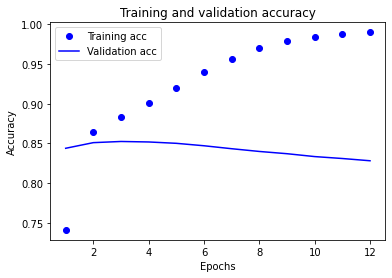

In [39]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

GlobalMaxPooling1D 적용

In [40]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 41)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 336       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 410,345
Trainable params: 410,345
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [42]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,callbacks=[es],
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 1s 4ms/step - loss: 0.5350 - accuracy: 0.7828 - val_loss: 0.3869 - val_accuracy: 0.8330
Epoch 2/20
229/229 [==============================] - 1s 3ms/step - loss: 0.3434 - accuracy: 0.8526 - val_loss: 0.3539 - val_accuracy: 0.8459
Epoch 3/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2982 - accuracy: 0.8749 - val_loss: 0.3511 - val_accuracy: 0.8480
Epoch 4/20
229/229 [==============================] - 1s 3ms/step - loss: 0.2687 - accuracy: 0.8901 - val_loss: 0.3563 - val_accuracy: 0.8473
Epoch 5/20
229/229 [==============================] - 1s 3ms/step - loss: 0.2438 - accuracy: 0.9034 - val_loss: 0.3632 - val_accuracy: 0.8451
Epoch 6/20
229/229 [==============================] - 1s 3ms/step - loss: 0.2220 - accuracy: 0.9136 - val_loss: 0.3761 - val_accuracy: 0.8463
Epoch 7/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2014 - accuracy: 0.9239 - val_loss: 0.3920 - val_accuracy: 0.8440
Epoch 

In [43]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5360 - accuracy: 0.8306
[0.5359633564949036, 0.8305633068084717]


In [44]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


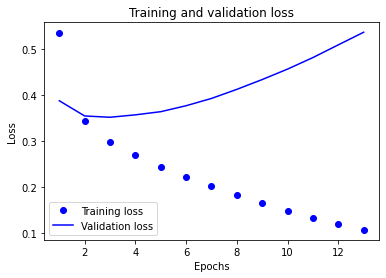

In [45]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

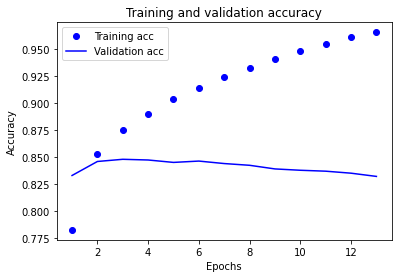

In [46]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Word2Vec 이용
비용을 절감, 정확도 향상, 자연어처리 기법, 단어의 특성을 저차원 벡터값으로 표현, word embedding.

In [47]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 41)


In [74]:
from collections import Counter
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

from gensim.models import Word2Vec
import os

In [99]:
from gensim.models import Word2Vec
import os

# 한국어 Word2Vec 사용
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'




In [ ]:
회고
1) 데이터 전처리
위에서 확인한 것처럼 데이터의 전처리가 필요해 보입니다.
데이터 중복을 제거
결측치 제거
한국어 토크나이저로 토큰화
불용어 제거
사전 word_to_index 구성
텍스트 스트링을 사전 인덱스 스트링으로 변환
X_train, y_train, X_test, y_test 리턴

2) 결과: (1) 1537/1537 - 12s - loss: 0.5411 - accuracy: 0.8364
[0.5410551428794861, 0.8363610506057739]
결과(2)  1537/1537 - 4s - loss: 0.8336 - accuracy: 0.8227
[0.8335745930671692, 0.8227109313011169]
결과 (3)  1537/1537 - 2s - loss: 0.5311 - accuracy: 0.8329
[0.5310723185539246, 0.8329434394836426]
결론 그래프와 Validation loss는 진행할 수록 떨어지고, 정확도 낮다. 언픽클링과 신텍스에라 키에라 인댁승라 등 많은 것을 경험하며 
해결하기위해 구글링을 통해서 많이 배웠습니다. 늘 감사드립니다.
reference 1)https://velog.io/@hwanython/%EB%84%A4%EC%9D%B4%EB%B2%84-%EC%98%81%ED%99%94%EB%A6%AC%EB%B7%B0-%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A5%BC-%EA%B0%80%EC%A7%80%EA%B3%A0-%EA%B0%90%EC%84%B1%EC%9D%84-%EB%B6%84%EC%84%9D
    2) https://lms.aiffel.io/course/357/node/504/step/3438
        3)https://chillog.page/159